# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import torch
import torchvision
import cv2
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('cuda not available')
else:
    print('cuda ok')

cuda ok


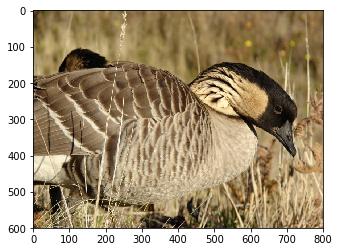

In [2]:
path = './images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg'
image_pil = Image.open(path)
image = np.array(image_pil)
plt.imshow(image)

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [3]:
import os
import shutil
train_data_dir = '/data/landmark_images/train'
test_data_dir = '/data/landmark_images/test'

print(os.path.isdir(train_data_dir))
print(os.path.isdir(test_data_dir))

print(len(os.listdir(train_data_dir)))
print(len(os.listdir(test_data_dir)))

train_folder = os.listdir(train_data_dir)
train_path = {}
train_paht_all = []

for file in train_folder:
    train_path[file] = os.listdir(train_data_dir +'/' +file)
    for png in train_path[file]:
        train_paht_all.append(train_data_dir +'/' +file + '/' + png)
    
test_folder = os.listdir(test_data_dir)
test_path = {}
test_path_all = []

for file in test_folder:
    test_path[file] = os.listdir(test_data_dir +'/' +file)
    for png in test_path[file]:
        test_path_all.append(test_data_dir +'/' +file + '/' + png)
len(test_path_all)

True
True
50
50


1250

In [4]:
num_workers = 0
batch_size = 20
valid_size = 0.2

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

test_transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

)




train_data_dir = '/data/landmark_images/train'
test_data_dir = '/data/landmark_images/test'

train_data = torchvision.datasets.ImageFolder(
                    root = train_data_dir,
                    transform = train_transform)

valid_data = torchvision.datasets.ImageFolder(
                    root = train_data_dir,
                    transform = test_transform)

test_data = torchvision.datasets.ImageFolder(
                    root = test_data_dir,
                    transform = test_transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: I resized image size to 224 because VGG16 fits its size.I use random horizontal flip, random rotation to increase the amount of train data. Because it needs more data to train well. But it should not be adjusted on test data.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [5]:
def imshow(img):
    img = img/2 + 0.5
    plt.imshow(np.transpose(img,(1,2,0)))

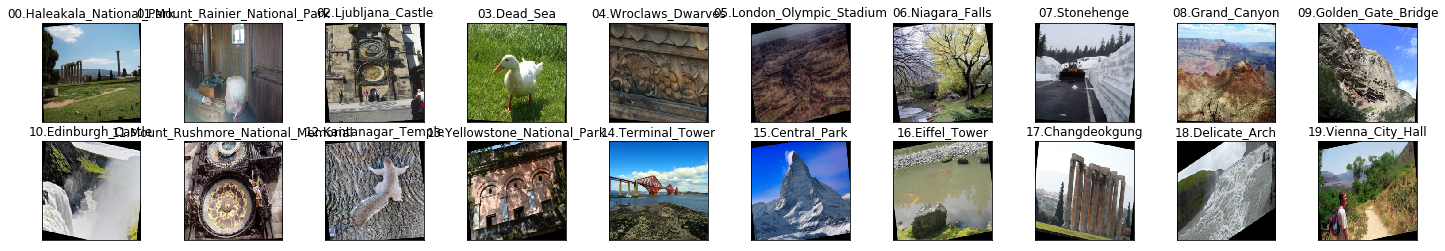

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
mn = images.min()
mx = images.max()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow((images[idx].transpose(1,2,0) - mn)/(mx-mn))
    ax.set_title(train_data.classes[idx])

### Initialize use_cuda variable

In [7]:
# useful variable that tells us whether we should use the GPU

use_cuda = torch.cuda.is_available()
use_cuda

True

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [8]:
## TODO: select loss function
import torch.optim as optim
import torch.nn as nn

criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    return optimizer
    
    ## TODO: select and return an optimizer
    
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        #self.conv4 = nn.Conv2d(64,128,3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64*28*28, 500)
        #self.fc1 = nn.Linear(128*14*14, 1000)

        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200,50)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1,64*28*28)
        #x = x.view(-1, 128 *14*14)
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        #x = self.fc2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


model_scratch = Net()
print(model_scratch)
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=50, bias=True)
  (dropout): Dropout(p=0.25)
)


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  I used three convolutional layers with maxpooling method applied. Then the nodes went into three fully connected layesrs to classify 50 different landmark images. While passing through the fc layers, dropout with 0.25 probability is applied in order to enhance the performance.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [10]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            #print('data',data.shape)
            #print('target',data.shape)
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            if batch_idx %20 ==0:
                train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss =criterion(output,target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

            ## TODO: update average validation loss 

            
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_classifier.pt')
            torch.save(model.state_dict(), 'checkpoint.pth')
            valid_loss_min = valid_loss
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [11]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.uniform_(0.0,1.0)
        m.bias.data.fill_(0)
    
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=50, bias=True)
  (dropout): Dropout(p=0.25)
)

In [12]:
model_scratch = train(1, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 238.073888 	Validation Loss: 0.000784
Validation loss decreased (inf --> 0.000784).  Saving model ...


### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [13]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 30

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)


# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_classifier.pt')

Epoch: 1 	Training Loss: 0.000782 	Validation Loss: 0.000761
Validation loss decreased (inf --> 0.000761).  Saving model ...
Epoch: 2 	Training Loss: 0.000709 	Validation Loss: 0.000723
Validation loss decreased (0.000761 --> 0.000723).  Saving model ...
Epoch: 3 	Training Loss: 0.000735 	Validation Loss: 0.000679
Validation loss decreased (0.000723 --> 0.000679).  Saving model ...
Epoch: 4 	Training Loss: 0.000656 	Validation Loss: 0.000653
Validation loss decreased (0.000679 --> 0.000653).  Saving model ...
Epoch: 5 	Training Loss: 0.000650 	Validation Loss: 0.000624
Validation loss decreased (0.000653 --> 0.000624).  Saving model ...
Epoch: 6 	Training Loss: 0.000519 	Validation Loss: 0.000611
Validation loss decreased (0.000624 --> 0.000611).  Saving model ...
Epoch: 7 	Training Loss: 0.000534 	Validation Loss: 0.000598
Validation loss decreased (0.000611 --> 0.000598).  Saving model ...
Epoch: 8 	Training Loss: 0.000525 	Validation Loss: 0.000602
Epoch: 9 	Training Loss: 0.000466 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [14]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.0
    correct = 0.0
    total = 0.0

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_classifier.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.782085


Test Accuracy: 29% (363/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [15]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

#loaders_transfer = {'train': None, 'valid': None, 'test': None

loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [16]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [17]:
## TODO: Specify model architecture
from torchvision import models

model_transfer = models.vgg16(pretrained=True)


print(model_transfer)

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 109656171.78it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  Since I used pretrained mode, 'vgg16', to solve out this classification problem, I have to handle some parts. I should make the parameters in vgg16 to be fixed, since they were already trained parameters but only should edit last fc layer's output size from 1000 to 50. So we only train the fixed last classifier layer part, and I will go similar process on the rest of parts.
And the reason why this vgg16 architecture is suitable for the current problem is that, vgg16 model is one of the best image classification models which ahcieved 92.7% on ImageNet Challenge. The problem in ImageNet Challenge and this 'landmark image classification' is somewhat similar problem which classifies images with CNN based models.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [17]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs,50)

model_transfer.classifier[6] = last_layer

if train_on_gpu:
    model_transfer.cuda()

valid_loss_min = np.inf
n_epochs = 15
for epoch in range(1,n_epochs+1):
    
    train_loss = 0.0
    valid_loss = 0.0
    
    model_transfer.train()
    for batch_i, (data,target) in enumerate(loaders_transfer['train']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        get_optimizer_transfer(model_transfer.classifier).zero_grad()
        output = model_transfer(data)
        loss = criterion_transfer(output, target)
        loss.backward()
        get_optimizer_transfer(model_transfer.classifier).step()
        

        if batch_i % 20 ==0:
            train_loss = train_loss + ((1 / (batch_i + 1)) * (loss.data.item() - train_loss))

    model_transfer.eval()
    for batch_i, (data,target) in enumerate(loaders_transfer['valid']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model_transfer(data)
        loss = criterion_transfer(output,target)
        valid_loss = valid_loss + ((1 / (batch_i + 1)) * (loss.data.item() - valid_loss))
    
    
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, 
        train_loss,
        valid_loss
        ))

    ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_transfer.state_dict(), 'model_transfer.pt')
        #torch.save(model_transfer.state_dict(), 'transfer_checkpoint.pth')
        valid_loss_min = valid_loss
            
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.001109 	Validation Loss: 0.000371
Validation loss decreased (inf --> 0.000371).  Saving model ...
Epoch: 2 	Training Loss: 0.000231 	Validation Loss: 0.000520
Epoch: 3 	Training Loss: 0.000478 	Validation Loss: 0.000919
Epoch: 4 	Training Loss: 0.000712 	Validation Loss: 0.000993
Epoch: 5 	Training Loss: 0.000655 	Validation Loss: 0.001284
Epoch: 6 	Training Loss: 0.001127 	Validation Loss: 0.001234
Epoch: 7 	Training Loss: 0.000961 	Validation Loss: 0.001307
Epoch: 8 	Training Loss: 0.001153 	Validation Loss: 0.001812
Epoch: 9 	Training Loss: 0.000442 	Validation Loss: 0.001402
Epoch: 10 	Training Loss: 0.002290 	Validation Loss: 0.001679
Epoch: 11 	Training Loss: 0.001426 	Validation Loss: 0.001725
Epoch: 12 	Training Loss: 0.001926 	Validation Loss: 0.002300
Epoch: 13 	Training Loss: 0.002316 	Validation Loss: 0.001313
Epoch: 14 	Training Loss: 0.000653 	Validation Loss: 0.001723
Epoch: 15 	Training Loss: 0.000467 	Validation Loss: 0.001638


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [18]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 2.082867


Test Accuracy: 63% (791/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [21]:
import torchvision.transforms as T

In [22]:
image = Image.open('brooklyn_bridge.png')

preprocess = T.Compose([
   T.Resize(256),
   T.CenterCrop(224),
   T.ToTensor(),
   T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

image = preprocess(image)
image = image.unsqueeze_(0)
image.shape

torch.Size([1, 4, 224, 224])

In [23]:
import cv2
from PIL import Image
import torchvision.transforms as T

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

train_on_gpu = torch.cuda.is_available()

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    to_tensor = transforms.Compose([transforms.ToTensor()])
    image = Image.open(img_path)
    image = image.resize((224,224))
    image = to_tensor(image).float()

    image.unsqueeze_(0)
            
                                    
    if train_on_gpu:
        image = image.cuda()
                                    
    model_transfer.eval()                   
    output = model_transfer(image)

    _,preds_tensor = torch.topk(output,k,1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
    
    predicted_k = []
    for idx_ in np.arange(k):
        predicted_k.append(train_data.classes[preds[idx_]])
    return predicted_k
    


# test on a sample image
predict_landmarks('./images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['09.Golden_Gate_Bridge',
 '38.Forth_Bridge',
 '30.Brooklyn_Bridge',
 '28.Sydney_Harbour_Bridge',
 '16.Eiffel_Tower']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In this picture of the: 
['09.Golden_Gate_Bridge', '38.Forth_Bridge', '30.Brooklyn_Bridge']


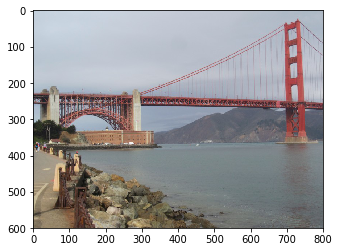

In [24]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

    img = plt.imread(img_path) 
    plt.imshow(img)

    print("In this picture of the: ")
    print(predicted_landmarks)

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.



__Answer:__ (Three possible points for improvement)
Since the model which is a first one I made on the top of this code's performacne was not great, the second model which is applied transfer learning process's outcome was better than I expected. Even though this performance is great, if I have more chances to improve this performance, I can do more pre processing works such as data augmentation to improve both the size of train data and also the results. Also, by having hyperparameter tuning, I can find the optimal hyperparameter when I have enough time and devices. Moreover, I can improve the performance when choosing not vgg16 but better SOTA model in imgage classification.

In [25]:

im1 = Image.open('brooklyn_bridge.png')
rgb_1 = im1.convert('RGB')
rgb_1.save('brooklyn_bridge.jpg')

im2 = Image.open('golden_gate_bridge.png')
rgb_2 = im2.convert('RGB')
rgb_2.save('golden_gate_bridge.jpg')

im3 = Image.open('niagara_fall.png')
rgb_3 = im3.convert('RGB')
rgb_3.save('niagara_fall.jpg')

im4 = Image.open('sydeny_harbour_bridge.png')
rgb_4 = im4.convert('RGB')
rgb_4.save('sydeny_harbour_bridge.jpg')

In this picture of the: 
['30.Brooklyn_Bridge', '29.Petronas_Towers', '16.Eiffel_Tower']


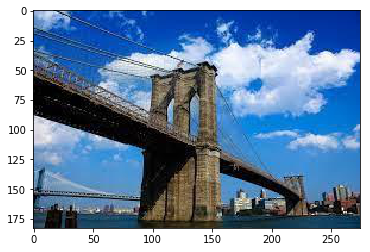

In [26]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('brooklyn_bridge.jpg')

In this picture of the: 
['09.Golden_Gate_Bridge', '30.Brooklyn_Bridge', '38.Forth_Bridge']


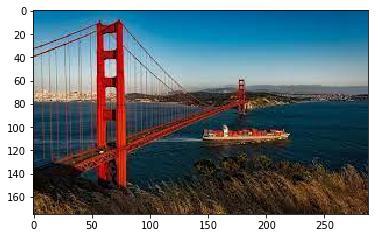

In [27]:
suggest_locations('golden_gate_bridge.jpg')

In this picture of the: 
['08.Grand_Canyon', '00.Haleakala_National_Park', '20.Matterhorn']


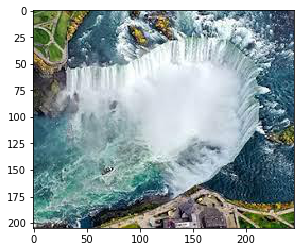

In [28]:
suggest_locations('niagara_fall.jpg')

In this picture of the: 
['28.Sydney_Harbour_Bridge', '38.Forth_Bridge', '30.Brooklyn_Bridge']


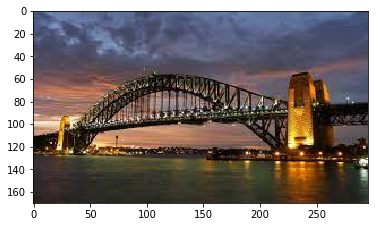

In [29]:
suggest_locations('sydeny_harbour_bridge.jpg')